In [1]:
# importing necessary libraries

%matplotlib inline
%config InlineBackend.figure_format='png'
from os.path import dirname
from os.path import join
import numpy as np
import scipy as sp# 
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_color_codes()

In [2]:
# Data Load
df = pd.read_csv("loan.csv", low_memory=False)
df = df[["annual_inc", "grade", "int_rate", "loan_amnt", "loan_status", "term", "dti","home_ownership", \
         "installment", "open_acc", "revol_bal", "revol_util", "total_acc"]]

# ["dti","home_ownership", "installment", "open_acc", "recoveries", "revol_bal", "revol_util", "total_acc"]

# remove nan values
df = df.dropna()


# Setting "loan status" to Target (remove uncertain loan status rows)
target_series = pd.Series(df["loan_status"])
a = target_series.isin(["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off",\
                        "Does not meet the credit policy. Status:Fully Paid", "Fully Paid"])
df = df[a]


# Changing Target to classes (1: default, 0: not default)
a = pd.Series(df["loan_status"])
b = a.replace(to_replace=["Charged Off", "Default", \
                          "Does not meet the credit policy. Status:Charged Off"], value=1)
y = b.replace(to_replace = ["Does not meet the credit policy. Status:Fully Paid", "Fully Paid"], value=0) 
# y is the target

df["loan_status"] = y


# home_ownership change : OWN=1, MORTGUAGE & RENT=0
a = np.array(df["home_ownership"])
b = np.zeros(len(df))

for i in range(len(b)):
    if a[i] == "OWN":
        b[i] = 1
        
df["home_ownership"] = b


# change "term" to integer
d = df["term"].replace(to_replace=[" 36 months"], value=36)
e = d.replace(to_replace=[" 60 months"], value=60)
e = np.array(e)
df["term"] = e


# change annaul income to monthly income
df["MonthlyIncome"] = df["annual_inc"]/12
df = df.drop("annual_inc", axis=1)


# change interest rate to percent
df["int_rate"] = df["int_rate"]/100


# make lendingclub's commission rate as "int_rate_lc"
"""
lendingclub's commission rate is set based on the below link:
    "https://www.lendingclub.com/public/borrower-rates-and-fees.action"

A = 3.34% (average value by lendingclub.com)
B = 5%
C ~ G = 6%
"""
grade = np.array(df['grade'])
int_rate_lc = np.zeros(len(grade))

for i in range(len(grade)):
    if grade[i]=="A":
        int_rate_lc[i]=0.0334
    elif grade[i]=="B":
        int_rate_lc[i]=0.05
    else:
        int_rate_lc[i]=0.06

df["int_rate_lc"] = int_rate_lc
df = df.drop("grade", axis=1)

# drop the target from data
df = df.drop("loan_status", axis=1)


# probability to default(p)
p = y.sum() / len(y)


# data and target
df.shape, len(y)

((256699, 12), 256699)

In [3]:
# peer-to-peer lending companies gather other people's money to make loans.
# This is a different environment with the conventional relationships between bank and customers.
# Therefore, I need to re-calculate the cost matrix for each loan.

# < Citation >
# Copyright (c) 2007 David Cournapeau <cournape@gmail.com>
#               2010 Fabian Pedregosa <fabian.pedregosa@inria.fr>
#               2010 Olivier Grisel <olivier.grisel@ensta.org>
#               2014 Alejandro CORREA BAHNSEN <al.bahnsen@gmail.com>
# License: BSD 3 clause


""" Setting parameters:

    loan_amnt: the amount of each loan
    int_rate: interest rate of each loan
    int_rate_lc: commission rate of each loan based on the loan's grade
    cl: line of credit of each customer(estimating that monthly times 3)
    n_term: repaying term of each loan (36month or 60month)
    l_gd: loss given default(75%, which is the standard for personal banking)
    target: the possibility to be classified to class1(default rate)
    
"""

loan_amnt_i = df["loan_amnt"]
int_rate_i = df["int_rate"]
int_rate_lc_i = df["int_rate_lc"]
cl_i = 3*df["MonthlyIncome"]
n_term_i = df["term"]
l_gd = .75
p = y.sum()/len(y)


# defining function to calculate C_fp : cost of the false positives
# c_fp = fee(borrower + investor) + c_fp(a)
# fee_bor: lendingclub's expected revenue (deducted from borrowers)
# fee_inv: lendingclub's expected revenue (deducted from investors)
# c_fp_a: lendingclub's expected revenue (generated by alternative customer; take the mean value)

def calculate_c_fp(loan_amnt_i, int_rate_lc_i, cl_i, l_gd, p):
    """Private function"""
    fee_bor = loan_amnt_i * int_rate_lc_i
    fee_inv = loan_amnt_i * n_term_i * 0.01 * (((int_rate_i)/12 * (1 + (int_rate_i)/12) ** n_term_i) / ((1 + (int_rate_i)/12) ** n_term_i - 1))
    c_fp_a = (-1)*(1-p)*((np.mean(loan_amnt_i * int_rate_lc_i)) + np.mean(fee_inv)) + p * np.mean(cl_i)*l_gd
    
    return np.array(fee_bor + fee_inv + c_fp_a)[:,np.newaxis]

c_fp = calculate_c_fp(loan_amnt_i, int_rate_lc_i, cl_i, l_gd, p)


# calculating C_fn : cost of the false negatives
# c_fn = l_gd*cl

c_fn = np.array(l_gd*cl_i)[:,np.newaxis]


# calculating C_tp & C_tn : cost of the true positives and true negatives
# set both of them to zero since this model accurately predicted so that loss cost is not generated  

c_tp = np.zeros(len(y))[:,np.newaxis]
c_tn = c_tp


# hstack each value to build costmatrices

cost_mat = np.hstack((c_fp, c_fn, c_tp, c_tn))

In [4]:
# Load classifiers and split dataset in training and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

np.random.seed(100)
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = \
train_test_split(df, y, cost_mat)

# Fit the classifiers using the training dataset
classifiers = {"RF": {"f": RandomForestClassifier()},
               "DT": {"f": DecisionTreeClassifier()},
               "LR": {"f": LogisticRegression()}}

In [5]:
for model in classifiers.keys():
    # Fit
    classifiers[model]["f"].fit(X_train, y_train)
    # Predict
    classifiers[model]["c"] = classifiers[model]["f"].predict(X_test)
    classifiers[model]["p"] = classifiers[model]["f"].predict_proba(X_test)
    classifiers[model]["p_train"] = classifiers[model]["f"].predict_proba(X_train)

In [6]:
# Evaluate the performance
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
measures = {"f1": f1_score, "pre": precision_score, 
            "rec": recall_score, "acc": accuracy_score}
results = pd.DataFrame(columns=measures.keys())

# Evaluate each model in classifiers
for model in classifiers.keys():
    results.loc[model] = [measures[measure](y_test, classifiers[model]["c"]) for measure in measures.keys()]

print(results)

         pre       rec       acc        f1
DT  0.248078  0.273947  0.714406  0.260371
RF  0.384520  0.079314  0.807760  0.131503
LR  0.370968  0.001953  0.816252  0.003886


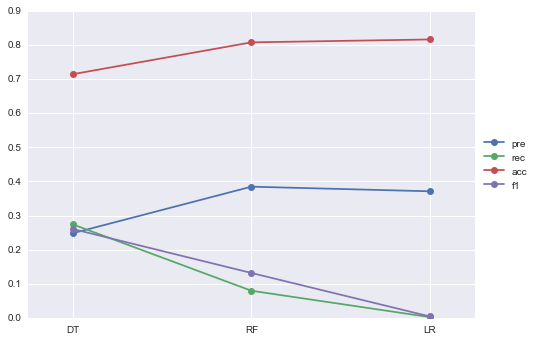

In [7]:
ax = plt.subplot(111)

ind = np.arange(results.shape[0])
width = 0.2
l = ax.plot(ind, results, "-o")
plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.25, ind[-1]+.25])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [8]:
# Calculation of the cost and savings
from costcla.metrics import savings_score, cost_loss 

# Evaluate the savings for each model
results["sav"] = np.zeros(results.shape[0])
for model in classifiers.keys():
    results["sav"].loc[model] = savings_score(y_test, classifiers[model]["c"], cost_mat_test)

# TODO: plot results
print(results)

         pre       rec       acc        f1       sav
DT  0.248078  0.273947  0.714406  0.260371  0.021194
RF  0.384520  0.079314  0.807760  0.131503 -0.018274
LR  0.370968  0.001953  0.816252  0.003886 -0.056706


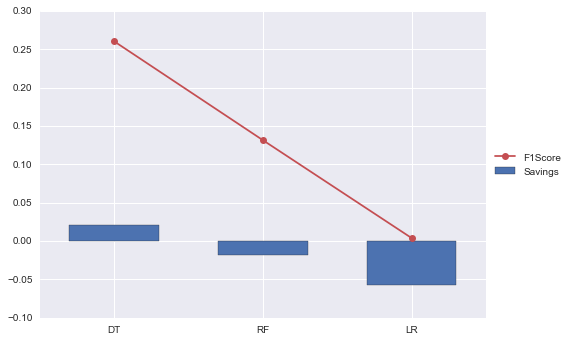

In [9]:
# Plot the results
colors = sns.color_palette()

ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [10]:
from costcla.models import BayesMinimumRiskClassifier
ci_models = classifiers.keys()

In [11]:
classifiers['DT'+"-BMR"] = {"f": BayesMinimumRiskClassifier()}
classifiers['LR'+"-BMR"] = {"f": BayesMinimumRiskClassifier()}
classifiers['RF'+"-BMR"] = {"f": BayesMinimumRiskClassifier()}

In [12]:
# calibration
classifiers['DT'+"-BMR"]["f"].fit(y_test, classifiers['DT']["p"])  
classifiers['LR'+"-BMR"]["f"].fit(y_test, classifiers['LR']["p"])  
classifiers['RF'+"-BMR"]["f"].fit(y_test, classifiers['RF']["p"])  

In [13]:
# predict
classifiers['DT'+"-BMR"]["c"] = classifiers['DT'+"-BMR"]["f"].predict(classifiers['DT']["p"], cost_mat_test)
classifiers['LR'+"-BMR"]["c"] = classifiers['LR'+"-BMR"]["f"].predict(classifiers['LR']["p"], cost_mat_test)
classifiers['RF'+"-BMR"]["c"] = classifiers['RF'+"-BMR"]["f"].predict(classifiers['RF']["p"], cost_mat_test)

In [14]:
# Evaluate
results.loc['DT'+"-BMR"] = 0
results.loc['DT'+"-BMR", measures.keys()] = \
[measures[measure](y_test, classifiers['DT'+"-BMR"]["c"]) for measure in measures.keys()]
results["sav"].loc['DT'+"-BMR"] = savings_score(y_test, classifiers['DT'+"-BMR"]["c"], cost_mat_test)

results.loc['LR'+"-BMR"] = 0
results.loc['LR'+"-BMR", measures.keys()] = \
[measures[measure](y_test, classifiers['LR'+"-BMR"]["c"]) for measure in measures.keys()]
results["sav"].loc['LR'+"-BMR"] = savings_score(y_test, classifiers['LR'+"-BMR"]["c"], cost_mat_test)

In [15]:
results.loc['RF'+"-BMR"] = 0
results.loc['RF'+"-BMR", measures.keys()] = \
[measures[measure](y_test, classifiers['RF'+"-BMR"]["c"]) for measure in measures.keys()]
results["sav"].loc['RF'+"-BMR"] = savings_score(y_test, classifiers['RF'+"-BMR"]["c"], cost_mat_test)

In [16]:
print(results)

             pre       rec       acc        f1       sav
DT      0.248078  0.273947  0.714406  0.260371  0.021194
RF      0.384520  0.079314  0.807760  0.131503 -0.018274
LR      0.370968  0.001953  0.816252  0.003886 -0.056706
DT-BMR  0.148595  0.388927  0.478956  0.215034  0.020933
LR-BMR  0.142916  0.380944  0.467191  0.207854 -0.018886
RF-BMR  0.201780  0.492867  0.549170  0.286334  0.124039


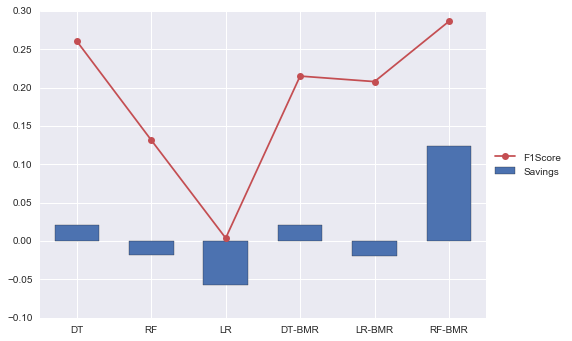

In [17]:
# Plot the results
ind = np.arange(results.shape[0])
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [18]:
from costcla.models import CostSensitiveDecisionTreeClassifier

classifiers["CSDT"] = {"f": CostSensitiveDecisionTreeClassifier()}

In [19]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [20]:
classifiers["CSDT"]["f"].fit(X_train, y_train, cost_mat_train)

CostSensitiveDecisionTreeClassifier(criterion='direct_cost',
                  criterion_weight=False, max_depth=None,
                  max_features=None, min_gain=0.001, min_samples_leaf=1,
                  min_samples_split=2, num_pct=100, pruned=True)

In [21]:
classifiers["CSDT"]["f"]

CostSensitiveDecisionTreeClassifier(criterion='direct_cost',
                  criterion_weight=False, max_depth=None,
                  max_features=None, min_gain=0.001, min_samples_leaf=1,
                  min_samples_split=2, num_pct=100, pruned=True)

In [22]:
classifiers["CSDT"]["c"] = classifiers["CSDT"]["f"].predict(X_test)

In [23]:
results.loc["CSDT"] = 0
results.loc["CSDT", measures.keys()] = \
[measures[measure](y_test, classifiers["CSDT"]["c"]) for measure in measures.keys()]
results["sav"].loc["CSDT"] = savings_score(y_test, classifiers["CSDT"]["c"], cost_mat_test)
    
print(results)

             pre       rec       acc        f1       sav
DT      0.248078  0.273947  0.714406  0.260371  0.021194
RF      0.384520  0.079314  0.807760  0.131503 -0.018274
LR      0.370968  0.001953  0.816252  0.003886 -0.056706
DT-BMR  0.148595  0.388927  0.478956  0.215034  0.020933
LR-BMR  0.142916  0.380944  0.467191  0.207854 -0.018886
RF-BMR  0.201780  0.492867  0.549170  0.286334  0.124039
CSDT    0.273978  0.612007  0.631212  0.378509  0.210481


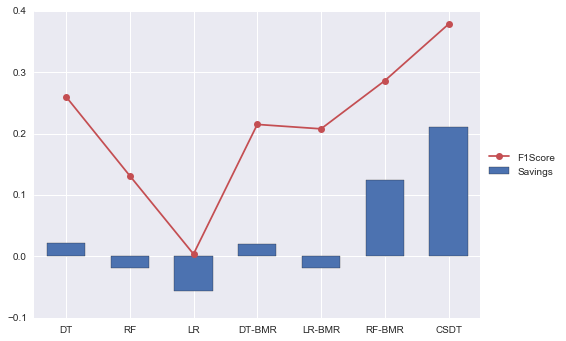

In [24]:
# Plot the results
ind = np.arange(results.shape[0])
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [25]:
from costcla.models import CostSensitiveRandomPatchesClassifier
classifiers["CSRP"] = {"f": CostSensitiveRandomPatchesClassifier(combination='weighted_voting')}
classifiers["CSRP"]["f"].fit(X_train, y_train, cost_mat_train)
classifiers["CSRP"]["c"] = classifiers["CSRP"]["f"].predict(X_test)

In [26]:
results.loc["CSRP"] = 0
results.loc["CSRP", measures.keys()] = \
[measures[measure](y_test, classifiers["CSRP"]["c"]) for measure in measures.keys()]
results["sav"].loc["CSRP"] = savings_score(y_test, classifiers["CSRP"]["c"], cost_mat_test)
    
print(results)

             pre       rec       acc        f1       sav
DT      0.248078  0.273947  0.714406  0.260371  0.021194
RF      0.384520  0.079314  0.807760  0.131503 -0.018274
LR      0.370968  0.001953  0.816252  0.003886 -0.056706
DT-BMR  0.148595  0.388927  0.478956  0.215034  0.020933
LR-BMR  0.142916  0.380944  0.467191  0.207854 -0.018886
RF-BMR  0.201780  0.492867  0.549170  0.286334  0.124039
CSDT    0.273978  0.612007  0.631212  0.378509  0.210481
CSRP    0.265847  0.664572  0.601683  0.379774  0.223632


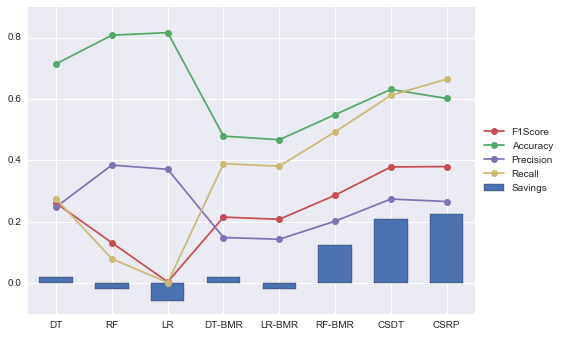

In [27]:
# Plot the results
ind = np.arange(results.shape[0])
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
a = ax.plot(ind, results["acc"], "-o", label='Accuracy', color=colors[1])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
c = ax.plot(ind, results["pre"], "-o", label='Precision', color=colors[3])
d = ax.plot(ind, results["rec"], "-o", label='Recall', color=colors[4])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [28]:
from sklearn.utils import column_or_1d

def cost_loss(y_true, y_pred, cost_mat):
    y_true = column_or_1d(y_true)
    y_true = (y_true == 1).astype(np.float)
    y_pred = column_or_1d(y_pred)
    y_pred = (y_pred == 1).astype(np.float)
    cost = y_true * ((1 - y_pred) * cost_mat[:, 1] + y_pred * cost_mat[:, 2])
    cost += (1 - y_true) * (y_pred * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3])
    return np.sum(cost)


In [29]:
# Calculating cost_base : the case where no model was used (Approved 100% or Disapproved 100% of loans)
# cost_base is the smaller one between Approved and Disapproved

cost_base = min(cost_loss(y_test, np.zeros(len(y_test)), cost_mat_test),\
                cost_loss(y_test, np.ones(len(y_test)), cost_mat_test))

In [30]:
# How much was actually saved by using CSDT and CSRP?

print("savings(CSDT): $ "+str(int(cost_base * results.loc["CSDT"]["sav"])))
print("savings(CSRP): $ "+str(int(cost_base * results.loc["CSRP"]["sav"])))

savings(CSDT): $ 29028473
savings(CSRP): $ 30842131


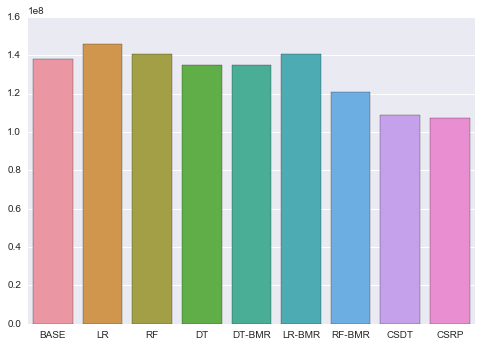

In [31]:
# Calculation of the actual amount of Costs induced by using each model

# objectify each model's Costs

RF = int(cost_base -cost_base * results.loc["RF"]["sav"])
DT = int(cost_base -cost_base * results.loc["DT"]["sav"])
LR = int(cost_base -cost_base * results.loc["LR"]["sav"])
DTBMR = int(cost_base -cost_base * results.loc["DT-BMR"]["sav"])
LRBMR = int(cost_base -cost_base * results.loc["LR-BMR"]["sav"])
RFBMR = int(cost_base -cost_base * results.loc["RF-BMR"]["sav"])
CSDT = int(cost_base -cost_base * results.loc["CSDT"]["sav"])
CSRP = int(cost_base -cost_base * results.loc["CSRP"]["sav"])

costs = np.array([cost_base, LR, RF, DT, DTBMR, LRBMR, RFBMR, CSDT, CSRP])
columns = ["BASE", "LR", "RF", "DT", "DT-BMR", "LR-BMR", "RF-BMR", "CSDT", "CSRP"]

# add one more dimensioin to make it 2X9 matrix
costs = costs[:, np.newaxis]

# Transform matrix to DataFrame
costs = pd.DataFrame(costs).T

costs.columns = columns

# plot the savings_cost
sns.barplot(data=costs)